# Predicting Orange Futures Prices Based on Weather

## CDS Algo Project S21

### Authors: Alex Lin, Brian Bobby, Divya Damodaran, Liam Bodurtha

In [56]:
from bs4 import BeautifulSoup
import matplotlib.pyplot as plt
from urllib.request import urlopen, Request
import nltk
from nltk.sentiment.vader import SentimentIntensityAnalyzer
import yfinance as yf
from datetime import date
import finplot as fplt
import requests
import pandas as pd
import numpy as np
import io
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import LogisticRegression
import seaborn as sns
from sklearn.metrics import accuracy_score
import statsmodels.api as sm
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import r2_score

In [2]:
r1 = requests.get('https://www.quandl.com/api/v3/datasets/CHRIS/ICE_OJ1.csv?api_key=9BZrqXiy4Mck8_br9oG9')
futures_data_1 = pd.read_csv(io.StringIO(r1.text))

r2 = requests.get('https://www.quandl.com/api/v3/datasets/CHRIS/ICE_OJ2.csv?api_key=9BZrqXiy4Mck8_br9oG9')
futures_data_2 = pd.read_csv(io.StringIO(r2.text))

r3 = requests.get('https://www.quandl.com/api/v3/datasets/CHRIS/ICE_OJ3.csv?api_key=9BZrqXiy4Mck8_br9oG9')
futures_data_3 = pd.read_csv(io.StringIO(r3.text))

r4 = requests.get('https://www.quandl.com/api/v3/datasets/CHRIS/ICE_OJ4.csv?api_key=9BZrqXiy4Mck8_br9oG9')
futures_data_4 = pd.read_csv(io.StringIO(r4.text))

r5 = requests.get('https://www.quandl.com/api/v3/datasets/CHRIS/ICE_OJ5.csv?api_key=9BZrqXiy4Mck8_br9oG9')
futures_data_5 = pd.read_csv(io.StringIO(r5.text))

In [3]:
counties = ['Hendry', 'DeSoto', 'Polk', 'Highlands', 'Hardee', 'St Lucie', 'Collier', 'Indian River', 'Manatee', 'Charlotte', 'Lee','Lake', 'Osceola', 'Glades', 'Okeechobee', 'Hillsborough', 'Pasco', 'Martin', 'Orange', 'Brevard', 'Sarasota', 'Marion', 'Volusia', 'Hernando', 'Seminole']
boxes = [14282, 12773, 12539, 9735, 8436, 6693, 6677, 5965, 3282, 2696, 2128, 1606, 1463, 1360, 152, 718, 687, 684, 351, 335, 212, 163, 111, 91, 43]
productionDf = pd.DataFrame({'County:': counties, 'Boxes Produced of Oranges(in 1000s)': boxes })
productionDf

,County:,Boxes Produced of Oranges(in 1000s)
0,Hendry,14282
1,DeSoto,12773
2,Polk,12539
3,Highlands,9735
4,Hardee,8436
5,St Lucie,6693
6,Collier,6677
7,Indian River,5965
8,Manatee,3282
9,Charlotte,2696


In [4]:
futures_data_1['Date'] = pd.to_datetime(futures_data_1['Date'])
futures_data_2['Date'] = pd.to_datetime(futures_data_2['Date'])
futures_data_3['Date'] = pd.to_datetime(futures_data_3['Date'])
futures_data_4['Date'] = pd.to_datetime(futures_data_4['Date'])
futures_data_5['Date'] = pd.to_datetime(futures_data_5['Date'])

futures_data_1['Settle_1'] = futures_data_1['Settle']
futures_data_2['Settle_2'] = futures_data_2['Settle']
futures_data_3['Settle_3'] = futures_data_3['Settle']
futures_data_4['Settle_4'] = futures_data_4['Settle']
futures_data_5['Settle_5'] = futures_data_5['Settle']
futures_data_5.head()

,Date,Open,High,Low,Settle,Change,Wave,Volume,Prev. Day Open Interest,EFP Volume,EFS Volume,Block Volume,Settle_5
0,2021-05-07,121.00,123.20,121.00,123.30,3.10,NaN,4.0,202.0,NaN,NaN,NaN,123.30
1,2021-05-06,119.35,119.35,119.35,120.20,2.45,NaN,1.0,201.0,NaN,NaN,NaN,120.20
2,2021-05-05,118.10,118.10,117.75,117.75,-1.30,NaN,8.0,197.0,NaN,NaN,NaN,117.75
3,2021-05-04,120.50,120.50,118.75,119.05,-1.50,NaN,77.0,120.0,NaN,NaN,NaN,119.05
4,2021-05-03,NaN,NaN,NaN,120.55,-0.20,NaN,0.0,120.0,NaN,NaN,NaN,120.55


In [5]:
station_county = pd.read_csv('station_county_matching.csv')
weather_station_dfs = {}
for station in station_county['Station']:
    dfname = station.lower().replace(' ','_')
    weather_station_dfs[dfname] = pd.read_csv('orangeCsvs/'+station+'.csv')



station_county[station_county['County'] == 'Collier']
stations_in_citrus_regions = []
for s in range(len(station_county.iloc[:,1].copy())):
    for c in counties:
        if c.lower().replace('saint', 'st') == station_county.iloc[s,1].lower():
              stations_in_citrus_regions.append(station_county.iloc[s,0].lower().replace(' ', '_'))
stations_in_citrus_regions.append('ft_pierce')
 #zero non-null rows - 3 more weather stations available for county 
print(stations_in_citrus_regions)


['arcadia', 'archbold_bio_stn', 'avon_park_2_w', 'bartow', 'bradenton_5_ese', 'brooksville_chin_hill', 'clermont_9_s', 'daytona_beach', 'daytona_beach_intl_ap', 'deland_1_sse', 'desoto_city_8_sw', 'devils_garden', 'fort_drum', 'ft_green_12_wsw', 'ft_myers_page_fld_ap', 'ft_pierce', 'hillsborough_river_sp', 'immokalee', 'kissimmee_2', 'la_belle', 'lisbon', 'melbourne_intl_ap', 'moore_haven_lock_1', 'mtn_lake', 'myakka_river_sp', 'naples', 'oasis_rs', 'ocala', 'okeechobee', 'orlando_intl_ap', 'parrish', 'plant_city', 'punta_gorda_4_ese', 'saint_leo', 'sanford', 'stuart', 'tampa_intl_ap', 'titusville', 'venice', 'vero_beach_intl_ap', 'vero_beach_4se', 'wauchula', 'weeki_wachee', 'ft_pierce']


In [6]:
fil_weather_station_dfs = (weather_station_dfs.fromkeys(stations_in_citrus_regions))

for station in stations_in_citrus_regions:
    fil_weather_station_dfs[station] = weather_station_dfs[station].copy() 

for dfname in stations_in_citrus_regions:
    fil_weather_station_dfs[dfname] = fil_weather_station_dfs[dfname][fil_weather_station_dfs[dfname]['year'] >= 1967]
    
print(len(fil_weather_station_dfs['oasis_rs']))
fil_weather_station_dfs['oasis_rs'].isnull().sum(axis = 0)    

14637


Unnamed: 0       0
id               0
year             0
month            0
day              0
precipitation    0
maxTemp          0
minTemp          0
meanTemp         0
dtype: int64

In [7]:
for station in stations_in_citrus_regions:
    df = fil_weather_station_dfs[station].copy()
    df['precipitation'] = df['precipitation'].astype(float)
    
    df['meanTemp'] = df['meanTemp'].replace(' ','-99.9')
    df['meanTemp'] = df['meanTemp'].astype('float64')
    
    fil_weather_station_dfs[station] = df

In [8]:
for station in stations_in_citrus_regions:
    fil_weather_station_dfs[station]['meanTemp'] = fil_weather_station_dfs[station]['meanTemp'].replace(-99.9, np.nan)
    
    fil_weather_station_dfs[station]['precipitation'] = fil_weather_station_dfs[station]['precipitation'].replace(-99.9, np.nan)
    
    fil_weather_station_dfs[station]['maxTemp'] = fil_weather_station_dfs[station]['maxTemp'].replace(-99.9, np.nan)
    
    fil_weather_station_dfs[station]['minTemp'] = fil_weather_station_dfs[station]['minTemp'].replace(-99.9, np.nan)


In [9]:
for station in stations_in_citrus_regions:
    fil_weather_station_dfs[station] = fil_weather_station_dfs[station].dropna()

In [10]:
fil_weather_station_dfs['arcadia'].isnull().sum(axis = 0)

Unnamed: 0       0
id               0
year             0
month            0
day              0
precipitation    0
maxTemp          0
minTemp          0
meanTemp         0
dtype: int64

In [11]:
for station in fil_weather_station_dfs.keys():
    print(station + ": " + str(len(fil_weather_station_dfs[station]['year'])))

arcadia: 17193
archbold_bio_stn: 17102
avon_park_2_w: 16668
bartow: 17317
bradenton_5_ese: 17267
brooksville_chin_hill: 15779
clermont_9_s: 17461
daytona_beach: 5005
daytona_beach_intl_ap: 17896
deland_1_sse: 16876
desoto_city_8_sw: 0
devils_garden: 15617
fort_drum: 13344
ft_green_12_wsw: 4862
ft_myers_page_fld_ap: 16994
ft_pierce: 17790
hillsborough_river_sp: 54
immokalee: 14594
kissimmee_2: 17107
la_belle: 14027
lisbon: 17552
melbourne_intl_ap: 2008
moore_haven_lock_1: 17760
mtn_lake: 17559
myakka_river_sp: 16715
naples: 17574
oasis_rs: 13227
ocala: 17675
okeechobee: 13338
orlando_intl_ap: 16736
parrish: 16696
plant_city: 17315
punta_gorda_4_ese: 17631
saint_leo: 17697
sanford: 17756
stuart: 16168
tampa_intl_ap: 17897
titusville: 16890
venice: 16311
vero_beach_intl_ap: 11686
vero_beach_4se: 17503
wauchula: 17417
weeki_wachee: 15215


In [12]:
for station in fil_weather_station_dfs.keys():
    if not station == 'desoto_city_8_sw':
        print(station + ": " + str(fil_weather_station_dfs[station]['year'].iloc[0]))

arcadia: 1967
archbold_bio_stn: 1969
avon_park_2_w: 1967
bartow: 1967
bradenton_5_ese: 1967
brooksville_chin_hill: 1967
clermont_9_s: 1967
daytona_beach: 2000
daytona_beach_intl_ap: 1967
deland_1_sse: 1967
devils_garden: 1967
fort_drum: 1967
ft_green_12_wsw: 2001
ft_myers_page_fld_ap: 1967
ft_pierce: 1967
hillsborough_river_sp: 1967
immokalee: 1970
kissimmee_2: 1967
la_belle: 1967
lisbon: 1967
melbourne_intl_ap: 2010
moore_haven_lock_1: 1967
mtn_lake: 1967
myakka_river_sp: 1968
naples: 1967
oasis_rs: 1978
ocala: 1967
okeechobee: 1967
orlando_intl_ap: 1967
parrish: 1967
plant_city: 1967
punta_gorda_4_ese: 1967
saint_leo: 1967
sanford: 1967
stuart: 1967
tampa_intl_ap: 1967
titusville: 1967
venice: 1967
vero_beach_intl_ap: 1984
vero_beach_4se: 1967
wauchula: 1967
weeki_wachee: 1969


In [13]:
station_county['Station'] = station_county['Station'].apply(lambda x: x.lower().replace(' ', '_'))
station_county['County'] = station_county['County'].apply(lambda x: x.lower().replace('saint', 'st'))

county_dfs = {}

for county in counties:
    if county == "St. Lucie":
        county = "St Lucie"
        
    county = county.lower()
    df = pd.DataFrame()
    
    for stat in station_county[station_county['County'] == county]['Station']:
        if stat in fil_weather_station_dfs.keys():
            
            temp_df = fil_weather_station_dfs[stat].copy()
            temp_df['County'] = county
        
            df = df.append(temp_df)
    
    county_dfs[county] = df


In [14]:
productionDf['County:'] = productionDf['County:'].apply(lambda x: x.lower().replace('st.', 'st'))

In [15]:
total_boxes = 0
for coun in county_dfs.keys():
    mult = int(productionDf[productionDf['County:'] == coun]['Boxes Produced of Oranges(in 1000s)'])
    total_boxes += mult
    county_dfs[coun] = (county_dfs[coun].groupby(['year', 'month', 'day']).mean())
    df = county_dfs[coun]
    df['minTemp'] = df['minTemp']*mult
    df['maxTemp'] = df['maxTemp']*mult
    df['meanTemp'] = df['meanTemp']*mult
    df['precipitation'] = df['precipitation']*mult

    df['weight'] = mult
    county_dfs[coun] = df
    print(len(df))

17191
17193
17866
17816
17534
17790
17890
17877
17824
17631
16994
17890
17107
17760
15788
17897
17697
16168
16736
17004
17761
17675
17897
17027
17756


In [16]:
final_df = pd.DataFrame()
for county in county_dfs.keys():
    final_df = final_df.append(county_dfs[county])
    
final_df = final_df.groupby(['year', 'month', 'day']).sum()

In [17]:
weighted_df = final_df.copy()
weighted_df['minTemp'] = weighted_df['minTemp']/weighted_df['weight']
weighted_df['maxTemp'] = weighted_df['maxTemp']/weighted_df['weight']
weighted_df['meanTemp'] = weighted_df['meanTemp']/weighted_df['weight']
weighted_df['precipitation'] = weighted_df['precipitation']/weighted_df['weight']

In [18]:
weighted_df['weight'] = weighted_df['weight']/total_boxes
weighted_df = weighted_df.reset_index().drop(columns = 'id')
weighted_df

,year,month,day,Unnamed: 0,precipitation,maxTemp,minTemp,meanTemp,weight
0,1967,1,1,356667.0,0.000000,82.188741,57.693862,69.941301,0.996405
1,1967,1,2,356691.0,0.001766,83.919400,64.216517,74.067959,0.996405
2,1967,1,3,356715.0,0.054087,84.421995,66.105835,75.263915,0.996405
3,1967,1,4,346854.0,0.273805,77.525333,58.580123,68.052728,0.980704
4,1967,1,5,356763.0,0.044887,64.437989,37.345455,50.891722,0.996405
...,...,...,...,...,...,...,...,...,...
17892,2017,12,27,741149.0,0.000000,78.693788,56.135374,67.414581,0.997392
17893,2017,12,28,735865.0,0.000006,80.268988,57.951979,69.110484,0.997392
17894,2017,12,29,735888.0,0.000646,76.406912,56.427280,66.417096,0.997392
17895,2017,12,30,697669.0,0.000020,70.360003,51.582042,60.971023,0.860316


In [19]:
weighted_df['Date'] = pd.to_datetime(weighted_df[['year', 'month', 'day']])
weighted_df = weighted_df.drop(columns = ['year', 'month', 'day'])
weighted_df.head()

,Unnamed: 0,precipitation,maxTemp,minTemp,meanTemp,weight,Date
0,356667.0,0.000000,82.188741,57.693862,69.941301,0.996405,1967-01-01
1,356691.0,0.001766,83.919400,64.216517,74.067959,0.996405,1967-01-02
2,356715.0,0.054087,84.421995,66.105835,75.263915,0.996405,1967-01-03
3,346854.0,0.273805,77.525333,58.580123,68.052728,0.980704,1967-01-04
4,356763.0,0.044887,64.437989,37.345455,50.891722,0.996405,1967-01-05


In [20]:
weighted_df.dtypes

Unnamed: 0              float64
precipitation           float64
maxTemp                 float64
minTemp                 float64
meanTemp                float64
weight                  float64
Date             datetime64[ns]
dtype: object

In [21]:
futures_and_weather_df = pd.merge(futures_data_1, weighted_df, how="inner", on="Date")
futures_and_weather_df = pd.merge(futures_data_2, futures_and_weather_df, how="inner", on="Date")
futures_and_weather_df = pd.merge(futures_data_3, futures_and_weather_df, how="inner", on="Date")
futures_and_weather_df = pd.merge(futures_data_4, futures_and_weather_df, how="inner", on="Date")
futures_and_weather_df = pd.merge(futures_data_5, futures_and_weather_df, how="inner", on="Date")
futures_and_weather_df.head()

,Date,Open,High,Low,Settle,Change,Wave,Volume,Prev. Day Open Interest,EFP Volume,...,EFP Volume_y,EFS Volume_y,Block Volume_y,Settle_1,Unnamed: 0,precipitation,maxTemp,minTemp,meanTemp,weight
0,2017-12-29,137.55,137.55,137.55,140.15,0.75,137.55,1.0,69.0,NaN,...,NaN,NaN,NaN,136.00,735888.0,0.000646,76.406912,56.427280,66.417096,0.997392
1,2017-12-28,NaN,NaN,NaN,139.40,3.05,NaN,NaN,69.0,NaN,...,NaN,NaN,NaN,136.70,735865.0,0.000006,80.268988,57.951979,69.110484,0.997392
2,2017-12-27,136.50,136.65,136.10,136.35,-0.35,136.52,13.0,64.0,NaN,...,52.0,NaN,NaN,133.15,741149.0,0.000000,78.693788,56.135374,67.414581,0.997392
3,2017-12-26,137.30,137.30,137.30,136.70,NaN,137.30,2.0,63.0,NaN,...,NaN,NaN,NaN,134.05,654768.0,0.000000,77.516503,54.505437,66.010970,0.788489
4,2017-12-22,NaN,NaN,NaN,138.55,-0.30,NaN,NaN,63.0,NaN,...,NaN,NaN,NaN,135.25,741034.0,0.003400,81.792918,61.542716,71.667817,0.997392


In [22]:
futures_and_weather_df = futures_and_weather_df[['Date', 'Settle_1', 'Settle_2', 'Settle_3', 'Settle_4', 'Settle_5', 'precipitation', 'minTemp', 'meanTemp', 'weight']]
futures_and_weather_df

,Date,Settle_1,Settle_2,Settle_3,Settle_4,Settle_5,precipitation,minTemp,meanTemp,weight
0,2017-12-29,136.00,136.85,137.80,139.65,140.15,0.000646,56.427280,66.417096,0.997392
1,2017-12-28,136.70,135.85,136.85,138.65,139.40,0.000006,57.951979,69.110484,0.997392
2,2017-12-27,133.15,132.35,133.75,135.45,136.35,0.000000,56.135374,67.414581,0.997392
3,2017-12-26,134.05,133.85,135.15,136.35,136.70,0.000000,54.505437,66.010970,0.788489
4,2017-12-22,135.25,135.90,136.95,138.00,138.55,0.003400,61.542716,71.667817,0.997392
...,...,...,...,...,...,...,...,...,...,...
8511,1967-07-06,38.55,40.05,41.25,42.35,36.75,0.300590,72.102694,81.237543,0.895527
8512,1967-07-05,38.25,40.00,41.40,42.20,36.65,0.230177,71.605480,80.951361,0.895527
8513,1967-05-31,41.00,42.50,43.15,42.50,38.30,0.130251,65.606643,80.191397,0.895527
8514,1967-05-29,41.70,42.80,43.45,42.80,39.00,0.003383,68.352625,81.427415,0.895527


# Try Classification of Up vs Down

In [23]:
new_df = futures_and_weather_df.drop(columns=['Settle_2', 'Settle_3', 'Settle_4', 'Settle_5', 'weight'])
n = len(new_df)
price_change = np.zeros(n)
is_winter = []
is_raining = np.zeros(n)
rain = np.zeros(n)
good_temp = np.zeros(n)

s=0
c=0
year_price = []
month_rain = 0


for i in range(n-1):
    cur = new_df['Settle_1'][i]
    prev = new_df['Settle_1'][i+1]
    if cur>prev:
        price_change[i] = 1
        
    date = new_df['Date'][i]
    temp = new_df['minTemp'][i]
    if date.month <= 2 or date.month == 12:
        is_winter.append(i)
        if temp>=35 and temp<=50:
            good_temp[i] = 1
    elif temp>=55 and temp<=100:
            good_temp[i] = 1
    
    r = new_df['precipitation'][i]
    if r>=0.1:
        is_raining[i] = 1
    rain[i] = np.exp(r)
    #month_rain += r
    #if i>=60:
    #    month_rain -= max(0,new_df['precipitation'][i-60])
    
        
    if date.year == new_df['Date'][i+1].year:
        s+= cur
        c+=1
    else:
        year_price.insert(0,s/c)
        s=0
        c=0
    
new_df['price_up'] = price_change
new_df['is_raining'] = is_raining
new_df['rain'] = rain
new_df['good_temp'] = good_temp

In [24]:
winter_df = new_df.iloc[is_winter]

winter_bin = winter_df[['is_raining','good_temp']]
winter_cont = winter_df[['rain','minTemp']]
winter_y = winter_df[['price_up']]

In [25]:
logreg_scores = []
svm_scores = []
knn_scores = []
for _ in range(20):
    X_train, X_test, y_train, y_test = train_test_split(winter_bin, winter_y, test_size=0.2)
    
    clf = SVC()
    clf.fit(X_train,y_train)
    predicted = clf.predict(X_test)
    svm_scores.append(accuracy_score(y_test,predicted))
    
    knn = KNeighborsClassifier(n_neighbors=5)
    knn.fit(X_train, y_train)
    predicted = knn.predict(X_test)
    knn_scores.append(accuracy_score(y_test,predicted))
    
    X_train, X_test, y_train, y_test = train_test_split(winter_cont, winter_y, test_size=0.2)
    logreg = LogisticRegression()
    logreg.fit(X_train, y_train)
    predicted = logreg.predict(X_test)
    logreg_scores.append(accuracy_score(y_test,predicted))

/opt/anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:724: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/opt/anaconda3/lib/python3.7/site-packages/sklearn/svm/base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:13: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  del sys.path[0]
/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warni

/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:13: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  del sys.path[0]
/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/opt/anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:724: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/opt/anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:724: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/opt/anaconda3/lib/py

/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:13: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  del sys.path[0]
/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/opt/anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:724: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/opt/anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:724: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/opt/anaconda3/lib/py

In [26]:
print("Logistic regression mean: " + str(np.mean(logreg_scores)))
print("SVM mean: " + str(np.mean(svm_scores)))
print("KNN mean: " + str(np.mean(knn_scores)))

Logistic regression mean: 0.519854721549637
SVM mean: 0.5278450363196128
KNN mean: 0.5044794188861986


## Model Training Starts Here

In [27]:
#### OJ1
total_df = futures_and_weather_df
temp = total_df[["meanTemp"]]
rain = total_df["precipitation"]
price = total_df["Settle_1"]

In [28]:
X = futures_and_weather_df[['minTemp']]
y = futures_and_weather_df['Settle_1']
linreg = LinearRegression().fit(X, y) #linear reg
#logreg = LogisticRegression().fit(x,y)
print('OJ1:')
print('Coef: ' + str(linreg.coef_))
print("r^2 score: {:.2f}".format(linreg.score(X, y)))

OJ1:
Coef: [0.02193403]
r^2 score: 0.00


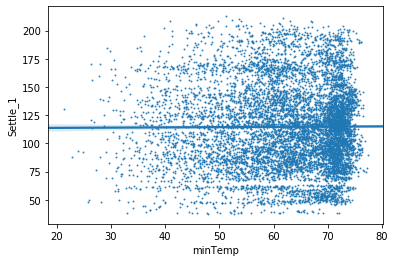

In [29]:
lin_regplot = sns.regplot(x="minTemp", y="Settle_1", data=futures_and_weather_df, scatter_kws={'s':1})

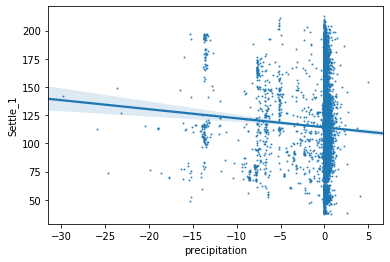

In [30]:
lin_regplot = sns.regplot(x="precipitation", y="Settle_1", data=futures_and_weather_df, scatter_kws={'s':1})

/opt/anaconda3/lib/python3.7/site-packages/pandas/plotting/_matplotlib/converter.py:103: FutureWarning: Using an implicitly registered datetime converter for a matplotlib plotting method. The converter was registered by pandas on import. Future versions of pandas will require you to explicitly register matplotlib converters.

To register the converters:
	>>> from pandas.plotting import register_matplotlib_converters
	>>> register_matplotlib_converters()
  warnings.warn(msg, FutureWarning)


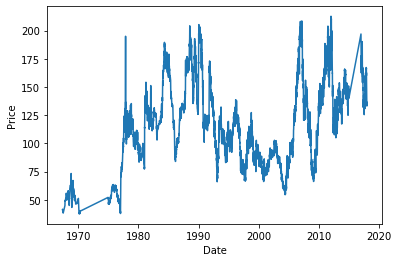

In [31]:
price = total_df[['Settle_1']].values
dates = futures_and_weather_df[['Date']].values
plt.plot(dates, price)
plt.xlabel('Date')
plt.ylabel('Price')
plt.show()

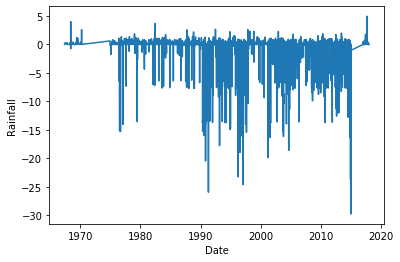

In [32]:
rain = total_df[['precipitation']].values
plt.plot(dates,rain)
plt.xlabel('Date')
plt.ylabel('Rainfall')
plt.show()

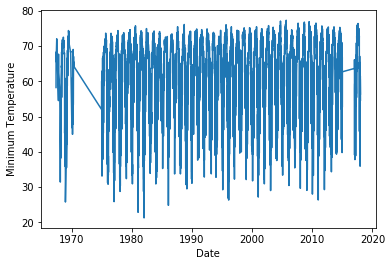

In [33]:
temp = total_df[['minTemp']].values
dates = total_df[['Date']].values
plt.plot(dates,temp)
plt.ylabel('Minimum Temperature')
plt.xlabel('Date')
plt.show()

In [34]:
from numpy import datetime64
winter = ['01','11','12'] #check for correlation for just winter months
recent = ['2017','2016','2015'] #thin out data set
old = ['2014','2013','2012']
dates = futures_and_weather_df[['Date']].values
winter_dates = []
recent_dates = []
recent_winters = []
old_dates = []
y2017 = []
y2014 = []

index = 0
for item in dates:
    time = str(item[0])
    time = time[:10]
    year = time[:4]
    month = time[5:7]
    y=int(year)
    if y >= 2014 and month in winter:
        y2017.append(index)
    if y == 2014 and month in winter:
        y2014.append(index)
    
    if month in winter:
        winter_dates.append(index)
    if year in recent:
        recent_dates.append(index)
    if month in winter and year in recent:
        recent_winters.append(index)
    if year in old:
        old_dates.append(index)
    index+=1

In [35]:
winter_df = futures_and_weather_df.iloc[winter_dates]
recent_df = futures_and_weather_df.iloc[recent_dates]
recent_winters_df = futures_and_weather_df.iloc[recent_winters]
old_df = futures_and_weather_df.iloc[old_dates]
df_2017 = futures_and_weather_df.iloc[y2017]
df_2014 = futures_and_weather_df.iloc[y2014]

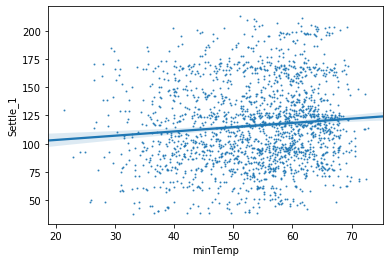

In [36]:
lin_regplot = sns.regplot(x="minTemp", y="Settle_1", data=winter_df, scatter_kws={'s':1})

# Bucketing Temp

In [37]:
df = futures_and_weather_df.copy()
df_winter = df[(df['Date'].map(lambda x: x.month) < 3) | (df['Date'].map(lambda x: x.month) == 12)]
df_winter['precipitation'] = np.exp(df_winter[['precipitation']].values)

/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


In [38]:
df_winter['D_29'] = (df_winter['minTemp'] <= 29).astype(int)
df_winter['D_32'] = ((df_winter['minTemp'] <= 32) & (df_winter['minTemp'] > 29)).astype(int)
df_winter['D_35'] = ((df_winter['minTemp'] <= 35) & (df_winter['minTemp'] > 32)).astype(int)

df_winter['D_29 * minTemp'] = df_winter['D_29'] * df_winter['minTemp']
df_winter['D_32 * minTemp'] = df_winter['D_32'] * df_winter['minTemp']
df_winter['D_35 * minTemp'] = df_winter['D_35'] * df_winter['minTemp']


df_winter['R_5'] = (df_winter['precipitation'] >= 5).astype(int)
df_winter['R_4'] = ((df_winter['precipitation'] >= 4) & (df_winter['precipitation'] < 5)).astype(int)
df_winter['R_3'] = ((df_winter['precipitation'] >= 3) & (df_winter['precipitation'] < 4)).astype(int)

df_winter['R_5 * precipitation'] = df_winter['R_5'] * df_winter['precipitation']
df_winter['R_4 * precipitation'] = df_winter['R_4'] * df_winter['precipitation']
df_winter['R_3 * precipitation'] = df_winter['R_3'] * df_winter['precipitation']

/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.
/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in t

In [131]:
n = len(df_winter)
prev_day = np.zeros(n)
pirce_up = np.zeros(n)
count=0

for index, _ in df_winter.iterrows():
    try:
        p = df_winter.loc[index+1, 'Settle_2']
        p2 = df_winter.loc[index+2, 'Settle_2']
    except: 
        p = df_winter.loc[index, 'Settle_2']
        p2 = df_winter.loc[index, 'Settle_2']
    prev_day[count] = p
    if p>p2:
        price_up[count] = 1
    count+=1
    
df_winter['prev_day_2'] = prev_day
df_winter['price_up'] = price_up

/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


In [40]:
df_winter.head()

,Date,Settle_1,Settle_2,Settle_3,Settle_4,Settle_5,precipitation,minTemp,meanTemp,weight,...,D_29 * minTemp,D_32 * minTemp,D_35 * minTemp,R_5,R_4,R_3,R_5 * precipitation,R_4 * precipitation,R_3 * precipitation,prev_day_2
0,2017-12-29,136.00,136.85,137.80,139.65,140.15,1.000646,56.427280,66.417096,0.997392,...,0.0,0.0,0.0,0,0,0,0.0,0.0,0.0,135.85
1,2017-12-28,136.70,135.85,136.85,138.65,139.40,1.000006,57.951979,69.110484,0.997392,...,0.0,0.0,0.0,0,0,0,0.0,0.0,0.0,132.35
2,2017-12-27,133.15,132.35,133.75,135.45,136.35,1.000000,56.135374,67.414581,0.997392,...,0.0,0.0,0.0,0,0,0,0.0,0.0,0.0,133.85
3,2017-12-26,134.05,133.85,135.15,136.35,136.70,1.000000,54.505437,66.010970,0.788489,...,0.0,0.0,0.0,0,0,0,0.0,0.0,0.0,135.90
4,2017-12-22,135.25,135.90,136.95,138.00,138.55,1.003406,61.542716,71.667817,0.997392,...,0.0,0.0,0.0,0,0,0,0.0,0.0,0.0,136.45


In [41]:
model2 = sm.OLS(df_winter['Settle_2'], sm.add_constant(df_winter[['minTemp', 'D_29', 'D_32', 'D_35', 'D_29 * minTemp', 'D_32 * minTemp', 'D_35 * minTemp', 'prev_day_2']])).fit()
model2.summary()

/opt/anaconda3/lib/python3.7/site-packages/numpy/core/fromnumeric.py:2495: FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.
  return ptp(axis=axis, out=out, **kwargs)


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:               Settle_2   R-squared:                       0.995
Model:                            OLS   Adj. R-squared:                  0.995
Method:                 Least Squares   F-statistic:                 4.780e+04
Date:                Sun, 09 May 2021   Prob (F-statistic):               0.00
Time:                        14:52:50   Log-Likelihood:                -5016.2
No. Observations:                2062   AIC:                         1.005e+04
Df Residuals:                    2053   BIC:                         1.010e+04
Df Model:                           8                                         
Covariance Type:            nonrobust                                         
==================================================================================
                     coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------
const              0.0765      0.434      0.176      0.860      -0.775       0.928
minTemp           -0.0004      0.008     -0.047      0.962      -0.015       0.015
D_29              17.6053      8.369      2.104      0.036       1.193      34.017
D_32             -29.0262     16.236     -1.788      0.074     -60.866       2.814
D_35              24.9486     15.173      1.644      0.100      -4.808      54.705
D_29 * minTemp    -0.6441      0.314     -2.049      0.041      -1.260      -0.028
D_32 * minTemp     0.9537      0.528      1.807      0.071      -0.081       1.989
D_35 * minTemp    -0.7563      0.451     -1.677      0.094      -1.641       0.128
prev_day_2         0.9995      0.002    613.756      0.000       0.996       1.003
==============================================================================
Omnibus:                     2101.047   Durbin-Watson:                   1.893
Prob(Omnibus):                  0.000   Jarque-Bera (JB):           561634.615
Skew:                           4.337   Prob(JB):                         0.00
Kurtosis:                      83.385   Cond. No.                     3.53e+04
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 3.53e+04. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [42]:
model2 = sm.OLS(df_winter['Settle_2'], sm.add_constant(df_winter[['minTemp', 'D_29', 'D_32', 'D_35','D_29 * minTemp', 'D_32 * minTemp','D_35 * minTemp']])).fit()
model2.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:               Settle_2   R-squared:                       0.015
Model:                            OLS   Adj. R-squared:                  0.011
Method:                 Least Squares   F-statistic:                     4.409
Date:                Sun, 09 May 2021   Prob (F-statistic):           7.14e-05
Time:                        14:52:50   Log-Likelihood:                -10396.
No. Observations:                2062   AIC:                         2.081e+04
Df Residuals:                    2054   BIC:                         2.085e+04
Df Model:                           7                                         
Covariance Type:            nonrobust                                         
==================================================================================
                     coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------
const             93.9199      5.515     17.030      0.000      83.105     104.735
minTemp            0.4430      0.104      4.259      0.000       0.239       0.647
D_29             -52.4295    113.631     -0.461      0.645    -275.274     170.415
D_32             397.7998    220.266      1.806      0.071     -34.168     829.768
D_35             -64.7905    206.031     -0.314      0.753    -468.841     339.260
D_29 * minTemp     2.2361      4.267      0.524      0.600      -6.132      10.604
D_32 * minTemp   -12.8395      7.160     -1.793      0.073     -26.881       1.202
D_35 * minTemp     1.7135      6.124      0.280      0.780     -10.297      13.724
==============================================================================
Omnibus:                      109.206   Durbin-Watson:                   0.035
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               56.955
Skew:                           0.234   Prob(JB):                     4.29e-13
Kurtosis:                       2.334   Cond. No.                     1.39e+04
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.39e+04. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

# Bucketing Rain

In [43]:
model2 = sm.OLS(df_winter['Settle_2'], \
                sm.add_constant(df_winter[['precipitation', 'R_3','R_4','R_5',\
                                           'R_3 * precipitation','R_4 * precipitation','R_5 * precipitation',\
                                           'prev_day_2']])).fit()
model2.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:               Settle_2   R-squared:                       0.995
Model:                            OLS   Adj. R-squared:                  0.995
Method:                 Least Squares   F-statistic:                 5.460e+04
Date:                Sun, 09 May 2021   Prob (F-statistic):               0.00
Time:                        14:52:50   Log-Likelihood:                -5017.3
No. Observations:                2062   AIC:                         1.005e+04
Df Residuals:                    2054   BIC:                         1.010e+04
Df Model:                           7                                         
Covariance Type:            nonrobust                                         
=======================================================================================
                          coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------
const                   0.0142      0.273      0.052      0.959      -0.521       0.549
precipitation           0.0468      0.173      0.270      0.787      -0.293       0.386
R_3                   -12.9153     14.163     -0.912      0.362     -40.691      14.860
R_4                     0.0404      0.124      0.326      0.745      -0.203       0.284
R_5                    24.5009      9.590      2.555      0.011       5.693      43.309
R_3 * precipitation     3.5846      4.198      0.854      0.393      -4.648      11.817
R_4 * precipitation     0.1889      0.580      0.326      0.745      -0.949       1.327
R_5 * precipitation    -2.5698      1.185     -2.169      0.030      -4.894      -0.246
prev_day_2              0.9994      0.002    613.973      0.000       0.996       1.003
==============================================================================
Omnibus:                     2101.146   Durbin-Watson:                   1.876
Prob(Omnibus):                  0.000   Jarque-Bera (JB):           559467.123
Skew:                           4.339   Prob(JB):                         0.00
Kurtosis:                      83.227   Cond. No.                     1.26e+19
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The smallest eigenvalue is 1.94e-31. This might indicate that there are
strong multicollinearity problems or that the design matrix is singular.
"""

In [129]:
model2 = sm.OLS(df_winter['Settle_2'], \
                sm.add_constant(df_winter[['minTemp','D_29', 'D_32', 'D_35',\
                                           'D_29 * minTemp','D_32 * minTemp','D_35 * minTemp',\
                                           'precipitation', 'R_3','R_4','R_5',\
                                           'R_3 * precipitation','R_4 * precipitation','R_5 * precipitation',\
                                           'prev_day_2','price_up']])).fit()
model2.summary()

/opt/anaconda3/lib/python3.7/site-packages/numpy/core/fromnumeric.py:2495: FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.
  return ptp(axis=axis, out=out, **kwargs)


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:               Settle_2   R-squared:                       0.997
Model:                            OLS   Adj. R-squared:                  0.997
Method:                 Least Squares   F-statistic:                 4.036e+04
Date:                Sun, 09 May 2021   Prob (F-statistic):               0.00
Time:                        16:29:43   Log-Likelihood:                -4541.2
No. Observations:                2062   AIC:                             9114.
Df Residuals:                    2046   BIC:                             9204.
Df Model:                          15                                         
Covariance Type:            nonrobust                                         
=======================================================================================
                          coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------
const                  -1.3867      0.373     -3.717      0.000      -2.118      -0.655
minTemp              3.079e-05      0.006      0.005      0.996      -0.012       0.012
D_29                   12.2261      6.660      1.836      0.067      -0.835      25.287
D_32                  -20.2750     12.920     -1.569      0.117     -45.612       5.062
D_35                   24.8680     12.073      2.060      0.040       1.192      48.544
D_29 * minTemp         -0.4574      0.250     -1.829      0.068      -0.948       0.033
D_32 * minTemp          0.6703      0.420      1.596      0.111      -0.153       1.494
D_35 * minTemp         -0.7466      0.359     -2.081      0.038      -1.450      -0.043
precipitation          -0.0139      0.138     -0.101      0.920      -0.284       0.257
R_3                    -5.9775     11.268     -0.530      0.596     -28.076      16.121
R_4                    -0.0279      0.099     -0.283      0.778      -0.222       0.166
R_5                    22.6978      7.628      2.976      0.003       7.738      37.658
R_3 * precipitation     1.7081      3.340      0.511      0.609      -4.842       8.258
R_4 * precipitation    -0.1305      0.462     -0.283      0.778      -1.036       0.775
R_5 * precipitation    -2.5133      0.942     -2.667      0.008      -4.362      -0.665
prev_day_2              0.9985      0.001    764.677      0.000       0.996       1.001
price_up                3.3393      0.097     34.358      0.000       3.149       3.530
==============================================================================
Omnibus:                     2921.227   Durbin-Watson:                   1.924
Prob(Omnibus):                  0.000   Jarque-Bera (JB):          2635482.559
Skew:                           7.650   Prob(JB):                         0.00
Kurtosis:                     177.473   Cond. No.                     8.74e+18
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The smallest eigenvalue is 4.72e-31. This might indicate that there are
strong multicollinearity problems or that the design matrix is singular.
"""

In [116]:
def price_movement(y_test, predicted):
    n = len(y_test)
    up_pred = np.zeros(n)
    up_obs = np.zeros(n)
    count = 0 
    for i in y_test.keys():
        up_pred[count] = (df_winter[['prev_day_2']].loc[i] < predicted.loc[i]).astype(int)
        up_obs[count] = (df_winter[['prev_day_2']].loc[i] < y_test.loc[i]).astype(int)
        count+=1
    return accuracy_score(up_obs, up_pred)

In [134]:
X = sm.add_constant(df_winter[['minTemp','D_29', 'D_32', 'D_35',\
                               'D_29 * minTemp','D_32 * minTemp','D_35 * minTemp',\
                               'precipitation', 'R_3','R_4','R_5',\
                               'R_3 * precipitation','R_4 * precipitation','R_5 * precipitation',\
                               'prev_day_2','price_up']])
y = df_winter['Settle_2']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.33, random_state = 85)

model1 = sm.OLS(y_train, X_train).fit()
predicted = model1.predict(X_test)
print('R2 of temp and prev day: ' + str(r2_score(y_test,predicted)))
print('Accuracy score of temp and prev day: ' + str(price_movement(y_test,predicted)))

R2 of temp and prev day: 0.9928012626475774
Accuracy score of temp and prev day: 0.7444933920704846


In [135]:
X = sm.add_constant(df_winter[['minTemp', 'precipitation','prev_day_2','price_up']])
y = df_winter['Settle_2']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.33, random_state = 85)

model_temp = sm.OLS(y_train, X_train).fit()
predicted = model_temp.predict(X_test)
print(r2_score(y_test,predicted))
print(price_movement(y_test,predicted))

/opt/anaconda3/lib/python3.7/site-packages/numpy/core/fromnumeric.py:2495: FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.
  return ptp(axis=axis, out=out, **kwargs)


0.9930085768272428
0.7415565345080763


In [136]:
X = sm.add_constant(df_winter[['prev_day_2']])
y = df_winter['Settle_2']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.9, random_state = 85)

model_temp = sm.OLS(y_train, X_train).fit()
predicted = model_temp.predict(X_test)
print('Baseline r2 w/ price change: ' + str(r2_score(y_test,predicted)))
print('Baseline accuracy score w/ price change: ' + str(price_movement(y_test,predicted)))

/opt/anaconda3/lib/python3.7/site-packages/numpy/core/fromnumeric.py:2495: FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.
  return ptp(axis=axis, out=out, **kwargs)


Baseline r2 w/ price change: 0.994582508109154
Baseline accuracy score w/ price change: 0.47521551724137934


In [137]:
X = sm.add_constant(df_winter[['prev_day_2','price_up']])
y = df_winter['Settle_2']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.9, random_state = 85)

model_temp = sm.OLS(y_train, X_train).fit()
predicted = model_temp.predict(X_test)
print('Baseline r2 w/ price change: ' + str(r2_score(y_test,predicted)))
print('Baseline accuracy score w/ price change: ' + str(price_movement(y_test,predicted)))

/opt/anaconda3/lib/python3.7/site-packages/numpy/core/fromnumeric.py:2495: FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.
  return ptp(axis=axis, out=out, **kwargs)


Baseline r2 w/ price change: 0.9952046440327406
Baseline accuracy score w/ price change: 0.7548491379310345
